Test an autoencoder using the MNIST dataset.  Below, import the relevant libraries, set some hyperparameters, define the network architecture, and define some helper functions.  Each image in the MNIST dataset is 28 x 28 pixels, so that's why the input layer is 28x28=784 nodes.  Source: https://stats.stackexchange.com/questions/190148/building-an-autoencoder-in-tensorflow-to-surpass-pca

For sure, the following works (listed under 'autoencoderAn.pt', where n is 1-4):
Batch size: 100
epochs: 20
learning rate: 0.000001

hidden1 = [1024, 512, 128, 64]
hidden2 = [512, 128, 64, 32]

elu, elu, linear, elu, elu, sigmoid

'autoencoderBn.pt': lr=0.0001
'autoencoderCn.pt': lr=0.001
'autoencoderDn.pt': lr=0.001, elu->relu
'autoencoderEn.pt': same as D but using 3 dimensions

TensorFlow and PyTorch have the same default parameters for the Adam optimizer.  In both cases, the default learning rate is 0.001.

In [138]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import math

BATCH_SIZE = 100
EPOCHS = 50
LEARNING_RATE = 0.001

class encoder(nn.Module):
    
    def __init__(self, hidden_dim1, hidden_dim2, encoded_dim):
        super(encoder, self).__init__()
        # fce = fully-connected encoder layer
        self.fce1 = nn.Linear(28 * 28, hidden_dim1)
        self.fce2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fce3 = nn.Linear(hidden_dim2, encoded_dim)
        
    def forward(self, x):
        x = F.elu(self.fce1(x))
        x = F.elu(self.fce2(x))
        x = self.fce3(x)
        return x
        

class decoder(nn.Module):
    
    def __init__(self, hidden_dim1, hidden_dim2, encoded_dim):
        super(decoder, self).__init__()
        # fcd = fully-connected decoder layer
        self.fcd1 = nn.Linear(encoded_dim, hidden_dim2)
        self.fcd2 = nn.Linear(hidden_dim2, hidden_dim1)
        self.fcd3 = nn.Linear(hidden_dim1, 28 * 28)
        
    def forward(self, x):
        x = F.elu(self.fcd1(x))
        x = F.elu(self.fcd2(x))
        x = torch.sigmoid(self.fcd3(x))
        return x


def load_mnist():
    """Load and normalize the MNIST dataset."""
    train_data = datasets.MNIST(root='./mnist/',
                                    train=True,
                                    download=True,
                                    transform=ToTensor())
    test_data = datasets.MNIST(root='./mnist/',
                                   train=False,
                                   download=True,
                                   transform=ToTensor())

    print("Training Data: {} / Labels: {}".format(train_data.data.size(), train_data.targets.size()))
    print("Test Data: {} / Labels: {}".format(test_data.data.size(), test_data.targets.size()))
    train_labels = train_data.targets
    train_data = torch.tensor(train_data.data, dtype=torch.float) / 255.
    test_labels = test_data.targets
    test_data = torch.tensor(test_data.data, dtype=torch.float) / 255.
    
    return train_data, train_labels, test_data, test_labels


def train(loader, optimizer, criterion, autoencoder):
    """Trains the given autoencoder using the data in loader, with a specified optimizer
        and loss criterion."""
    loss_history = np.zeros((1,))
    for epoch in range(EPOCHS):
        for i, batch_images in enumerate(loader):
            # Dimensions of batch_images: torch.tensor(batch_size, 28, 28)
            optimizer.zero_grad()                # Reset the gradient
            batch_images = torch.tensor(batch_images.view(BATCH_SIZE, 28 * 28),
                                        dtype=torch.float) # Reshape the image dims
            out = autoencoder(batch_images)      # Obtain output from current network
            loss = criterion(out, batch_images)  # Compare output with original images to generate loss
            loss.backward()                      # Perform backpropagation to get gradient
            optimizer.step()                     # Apply gradient to update network parameters

        loss_history = np.append(loss_history, loss.item())
        print('epoch {}/{} \t Loss: {}'.format(epoch+1, EPOCHS, loss.item()))
    
    return autoencoder, loss_history, epoch

Load the data, and create a data loader for batch processing.

In [139]:
# Load the MNIST dataset, and normalize
train_data, train_labels, test_data, test_labels = load_mnist()

# For mini-batch processing.  Dimensions: (BATCH_SIZE, 28, 28)
loader = DataLoader(dataset=train_data,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    num_workers=4)

Training Data: torch.Size([60000, 28, 28]) / Labels: torch.Size([60000])
Test Data: torch.Size([10000, 28, 28]) / Labels: torch.Size([10000])


c:\users\nick\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\users\nick\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Construct all architectures, and train them.

In [141]:
hidden1 = [1024, 512, 128, 64]
hidden2 = [512, 128, 64, 32]
encoder_dim = 2
network_names = ['autoencoder1.pt', 'autoencoder2.pt', 'autoencoder3.pt', 'autoencoder4.pt']
loss_histories = np.zeros((1, EPOCHS))

for i in range(4):
    # Set up the network.  Reference name != class name, so you can reset it each iteration
    encoder_i = encoder(hidden1[i], hidden2[i], encoder_dim)
    decoder_i = decoder(hidden1[i], hidden2[i], encoder_dim)
    autoencoder_i = nn.Sequential(encoder_i, decoder_i)
    print('\nNetwork architecture:'), print(autoencoder_i)
    
    # Choose optimizer and loss criterion, and train network
    optimizer = torch.optim.Adam(autoencoder_i.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()
    autoencoder_i, loss_history, epoch = train(loader, optimizer, criterion, autoencoder_i)
    loss_histories = np.row_stack((loss_histories, loss_history[1:]))

    # Save network parameters
    torch.save({'epoch': epoch,
                'model_state_dict': autoencoder_i.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss_history': loss_history[1:]}, network_names[i])

loss_histories = loss_histories[1:, :]
np.save('loss_histories.npy', loss_histories)


Network architecture:
Sequential(
  (0): encoder(
    (fce1): Linear(in_features=784, out_features=1024, bias=True)
    (fce2): Linear(in_features=1024, out_features=512, bias=True)
    (fce3): Linear(in_features=512, out_features=2, bias=True)
  )
  (1): decoder(
    (fcd1): Linear(in_features=2, out_features=512, bias=True)
    (fcd2): Linear(in_features=512, out_features=1024, bias=True)
    (fcd3): Linear(in_features=1024, out_features=784, bias=True)
  )
)


c:\users\nick\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch 1/50 	 Loss: 0.04553806409239769
epoch 2/50 	 Loss: 0.03958504647016525
epoch 3/50 	 Loss: 0.039753977209329605
epoch 4/50 	 Loss: 0.03895743563771248
epoch 5/50 	 Loss: 0.04201889410614967
epoch 6/50 	 Loss: 0.039394453167915344
epoch 7/50 	 Loss: 0.0380115807056427
epoch 8/50 	 Loss: 0.03941287100315094
epoch 9/50 	 Loss: 0.03618726134300232
epoch 10/50 	 Loss: 0.03596113994717598
epoch 11/50 	 Loss: 0.03562093898653984
epoch 12/50 	 Loss: 0.03563784807920456
epoch 13/50 	 Loss: 0.03612137213349342
epoch 14/50 	 Loss: 0.03698832541704178
epoch 15/50 	 Loss: 0.03731733188033104
epoch 16/50 	 Loss: 0.03622686490416527
epoch 17/50 	 Loss: 0.034492556005716324
epoch 18/50 	 Loss: 0.036447782069444656
epoch 19/50 	 Loss: 0.039288509637117386
epoch 20/50 	 Loss: 0.03207504749298096
epoch 21/50 	 Loss: 0.03303657844662666
epoch 22/50 	 Loss: 0.03642307221889496
epoch 23/50 	 Loss: 0.035327885299921036
epoch 24/50 	 Loss: 0.03225695714354515
epoch 25/50 	 Loss: 0.03540820628404617
epoc

epoch 22/50 	 Loss: 0.039678674191236496
epoch 23/50 	 Loss: 0.03987490385770798
epoch 24/50 	 Loss: 0.03973863646388054
epoch 25/50 	 Loss: 0.03538592904806137
epoch 26/50 	 Loss: 0.03676670417189598
epoch 27/50 	 Loss: 0.03861044719815254
epoch 28/50 	 Loss: 0.03831063210964203
epoch 29/50 	 Loss: 0.03883709758520126
epoch 30/50 	 Loss: 0.03981117531657219
epoch 31/50 	 Loss: 0.03669296205043793
epoch 32/50 	 Loss: 0.03738011047244072
epoch 33/50 	 Loss: 0.03616856783628464
epoch 34/50 	 Loss: 0.03986774757504463
epoch 35/50 	 Loss: 0.03867039829492569
epoch 36/50 	 Loss: 0.040744420140981674
epoch 37/50 	 Loss: 0.03533490002155304
epoch 38/50 	 Loss: 0.039387673139572144
epoch 39/50 	 Loss: 0.036892492324113846
epoch 40/50 	 Loss: 0.03712986037135124
epoch 41/50 	 Loss: 0.03792354837059975
epoch 42/50 	 Loss: 0.036476705223321915
epoch 43/50 	 Loss: 0.03834517300128937
epoch 44/50 	 Loss: 0.039039596915245056
epoch 45/50 	 Loss: 0.037653762847185135
epoch 46/50 	 Loss: 0.03904256597

Plot all loss histories.

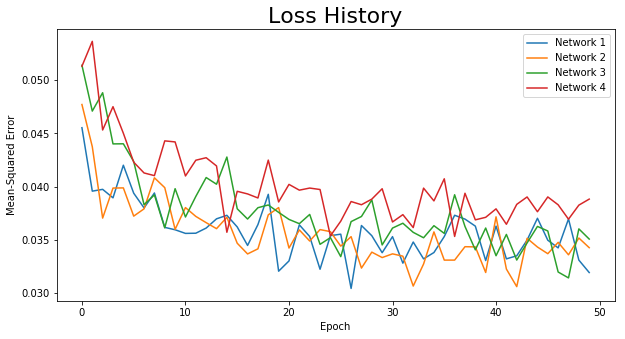

In [142]:
loss_histories = np.load('loss_histories.npy')

plt.figure(figsize=(10, 5))
plt.title("Loss History", fontsize=22)
for i in range(4):
    plt.plot(np.arange(EPOCHS), loss_histories[i, :])
plt.xlabel("Epoch"), plt.ylabel("Mean-Squared Error")
plt.legend(["Network {}".format(i) for i in range(1, 5, 1)])
# plt.savefig('./figures/loss.png', bbox_inches='tight')

Construct the encoder and decoder portions separately.  A bit hacky, but it works.

In [149]:
def apply_encoder(encoderi, data):
    """Run training data through the encoder to get the encoded data."""
    encoded_data = np.zeros((1, encoder_dim))
    for idx, i in enumerate(data):
        i_encoded = encoderi(i.type(torch.FloatTensor).view(1, 28 * 28))
        i_encoded = i_encoded.detach().numpy()
        encoded_data = np.row_stack((encoded_data, i_encoded))
        if (idx+1) % 5000 == 0:
            print('{}/{} images through encoder'.format(idx+1, train_data.size(0)))
    return encoded_data[1:, :]

def apply_decoder(decoderi, data):
    """Run some sample data through the decoder to get images"""
    decoded_data = []
    for idx, i in enumerate(data):
        i_decoded = decoderi(torch.tensor(i, dtype=torch.float))
        decoded_data.append(i_decoded.view(28, 28).detach().numpy())
    return decoded_data

# Choose the first 10 images
num_samples = 10
test_image_samples = test_data[:num_samples, :]
encoded_data_matrix = []  # 2-dimensional compressed data points (training)
encoded_test_matrix = []  # 2-dimensional compressed data points (test)
all_samples = []          # Results of running original images through autoencoder

# Generate 8 evenly-spaced points around origin of embedded space for running through decoder
sample_pts = np.array([[20*math.cos(a), 20*math.sin(a)] for a in np.arange(0, 2*math.pi, math.pi / 4)])
decoded_data_matrix = []  # For storing decoder results

for i in range(4):
    # Construct an autoencoder and its encoder/decoder networks
    encoder_i = encoder(hidden1[i], hidden2[i], encoder_dim)
    decoder_i = decoder(hidden1[i], hidden2[i], encoder_dim)
    autoencoder_i = nn.Sequential(encoder_i, decoder_i)
        
    # Load network parameters into autoencoder
    checkpoint = torch.load(network_names[i])
    autoencoder_i.load_state_dict(checkpoint['model_state_dict'])

    # Get encoded data by copying network parameters of encoder portion
    params = autoencoder_i.state_dict()

    # Manually assemble encoder/decoder parameters from the autoencoder parameters
    # (There's probably a better way to do this, but I got stuck using this method.  Plus,
    # this way you just have to save the autoencoder parameters instead of encoder/decoder
    # parameters in separate files)
    enc_params = {'fce1.weight': params['0.fce1.weight'],
             'fce1.bias': params['0.fce1.bias'],
             'fce2.weight': params['0.fce2.weight'],
             'fce2.bias': params['0.fce2.bias'],
             'fce3.weight': params['0.fce3.weight'],
             'fce3.bias': params['0.fce3.bias']}
    encoder_i.load_state_dict(enc_params)
    
    dec_params = {'fcd1.weight': params['1.fcd1.weight'],
             'fcd1.bias': params['1.fcd1.bias'],
             'fcd2.weight': params['1.fcd2.weight'],
             'fcd2.bias': params['1.fcd2.bias'],
             'fcd3.weight': params['1.fcd3.weight'],
             'fcd3.bias': params['1.fcd3.bias']}
    decoder_i.load_state_dict(dec_params)
    
    # Get encoded data
    print("Using encoder {}...".format(i+1))
    encoded_data = apply_encoder(encoder_i, train_data)
    encoded_test = apply_encoder(encoder_i, test_data)
    encoded_data_matrix.append(encoded_data)
    encoded_test_matrix.append(encoded_test)
        
    # Run the random test images through the full autoencoder
    print("Running data through autoencoder...")
    for j in range(num_samples):
        # Run through full autoencoder
        result = autoencoder_i(test_image_samples[j, :, :].view(1, 28 * 28))
        all_samples.append(result)
    
    # Run some sample points through the decoder
    print("Running sample points through decoder...")
    decoded_data_matrix.append(apply_decoder(decoder_i, sample_pts))

encoded_data_matrix = np.stack(encoded_data_matrix, axis=0)
encoded_test_matrix = np.stack(encoded_test_matrix, axis=0)

Using encoder 1...
5000/60000 images through encoder
10000/60000 images through encoder
15000/60000 images through encoder
20000/60000 images through encoder
25000/60000 images through encoder
30000/60000 images through encoder
35000/60000 images through encoder
40000/60000 images through encoder
45000/60000 images through encoder
50000/60000 images through encoder
55000/60000 images through encoder
60000/60000 images through encoder
5000/60000 images through encoder
10000/60000 images through encoder
Running data through autoencoder...
Running sample points through decoder...
Using encoder 2...
5000/60000 images through encoder
10000/60000 images through encoder
15000/60000 images through encoder
20000/60000 images through encoder
25000/60000 images through encoder
30000/60000 images through encoder
35000/60000 images through encoder
40000/60000 images through encoder
45000/60000 images through encoder
50000/60000 images through encoder
55000/60000 images through encoder
60000/60000 i

I: Apply full autoencoder

Using the all_samples array, plot some sample image results.  Thanks to the following source for removing ticks: https://stackoverflow.com/questions/2176424/hiding-axis-text-in-matplotlib-plots

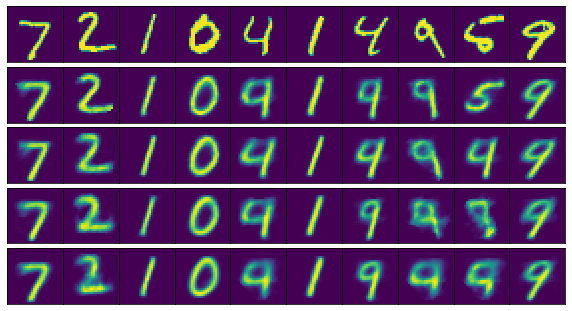

In [150]:
plt.figure(figsize=(10, 10))
for net in range(5):
    for sample in range(num_samples):
        if net == 0:  # Original images
            ax = plt.subplot(5, num_samples, sample+1)
            top = plt.imshow(test_image_samples[sample, :, :].detach().numpy())
            top.axes.get_xaxis().set_visible(False)
            top.axes.get_yaxis().set_visible(False)
            if sample == 0:
                plt.ylabel("original")
        else:  # Autoencoder results
            ax = plt.subplot(5, num_samples, sample+1+(net*num_samples))
            bottom = plt.imshow(all_samples[sample+(net-1)*num_samples].view(28, 28).detach().numpy())
            bottom.axes.get_xaxis().set_visible(False)
            bottom.axes.get_yaxis().set_visible(False)
plt.subplots_adjust(wspace=0, hspace=-0.8)
# plt.savefig('./figures/digit_results.png', bbox_inches='tight')

II: Apply encoder

Plot the training data in the reduced-dimensional space.

c:\users\nick\appdata\local\programs\python\python37\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


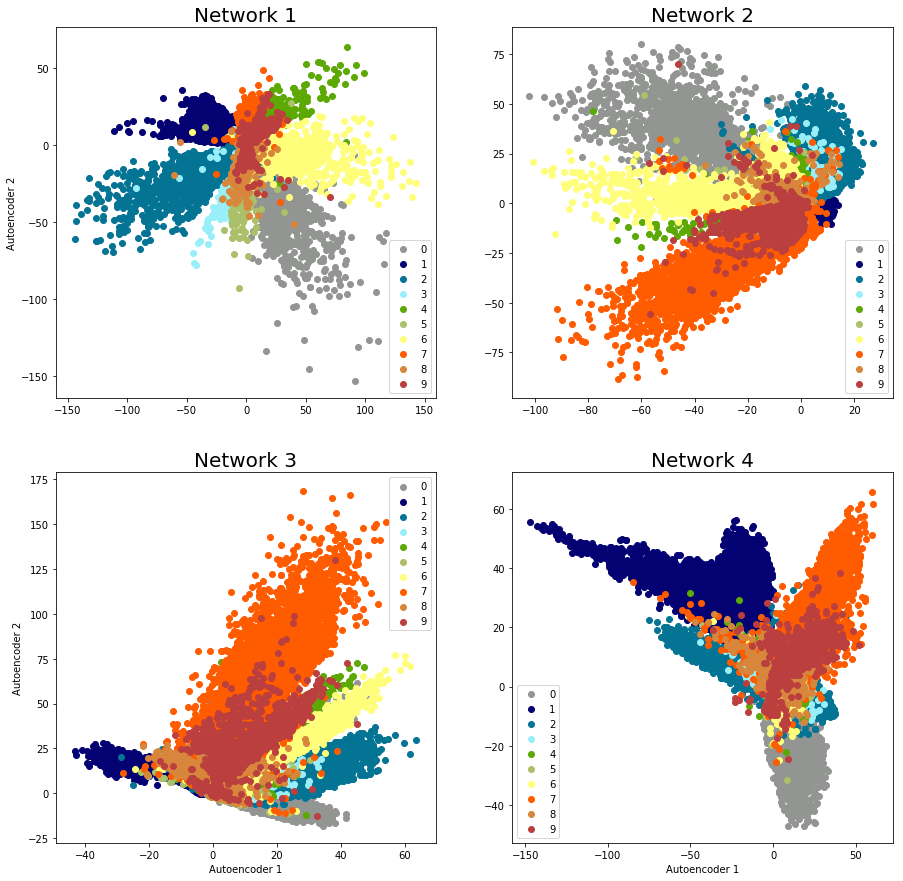

In [151]:
# Plot embedded data
colors = ['xkcd:grey', 'xkcd:deep blue', 'xkcd:sea blue',
          'xkcd:robin\'s egg blue', 'xkcd:leaf green', 'xkcd:light olive',
          'xkcd:light yellow', 'xkcd:bright orange', 'xkcd:dull orange',
          'xkcd:dull red']

plt.figure(figsize=(15, 15))
encoded_data = encoded_data_matrix[:train_data.size(0), :]
for net in range(4):
    for i, color in enumerate(colors):
        plt.subplot(2, 2, net+1)
        plt.title("Network {}".format(net+1), fontsize=20)
        number = encoded_data[net, np.where(train_labels == i), :][0, :, :]
        if net == 0 or net == 2:
            plt.ylabel("Autoencoder 2")
        if net == 2 or net == 3:
            plt.xlabel("Autoencoder 1")
        plt.scatter(number[:, 0], number[:, 1], label=i, c=color)
    plt.legend()
# plt.savefig('./figures/compressed_data.png', bbox_inches='tight')

For plotting in a 3-dimensional reduced space

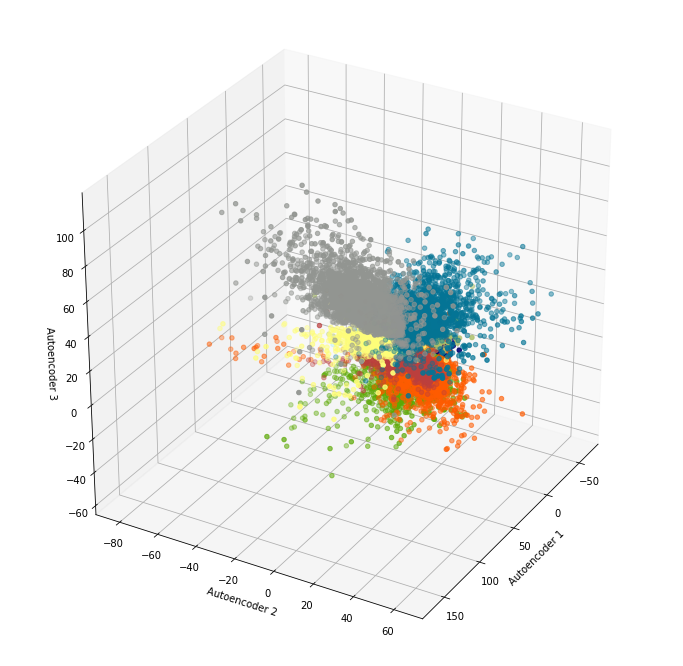

<Figure size 432x288 with 0 Axes>

In [16]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 12))
plt.title("Autoencoder projecting to 3-dimensional space")
ax = fig.add_subplot(111, projection='3d')
for i, color in enumerate(colors):
    number = encoded_data[np.where(train_labels == i), :][0, :, :]
    ax.scatter(number[:, 0], number[:, 1], number[:, 2], label=i, c=color)
ax.set_xlabel('Autoencoder 1')
ax.set_ylabel('Autoencoder 2')
ax.set_zlabel('Autoencoder 3')
ax.view_init(azim=30)
plt.show()

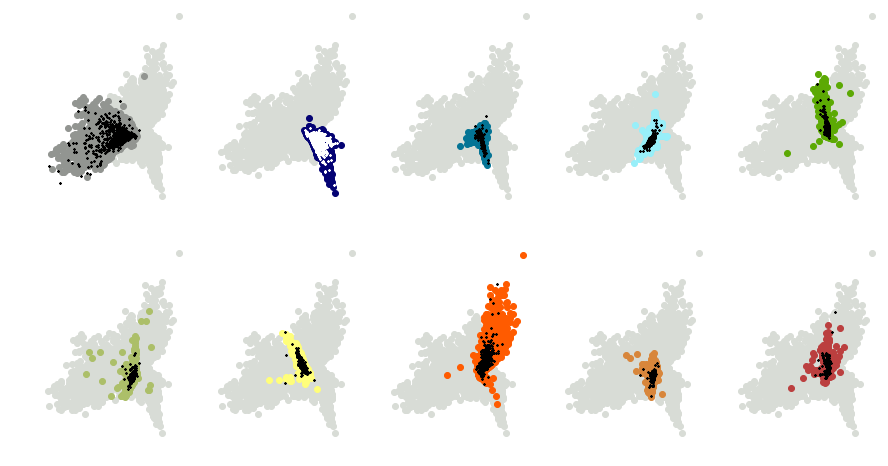

In [62]:
fig, ax = plt.subplots(2, 5, figsize=(15, 8))
for i in range(10):
    ax=plt.subplot(2, 5, i+1)
    other_nums = encoded_data_matrix[0, np.where(train_labels != i), :][0, :, :]

    number = encoded_data_matrix[0, np.where(train_labels == i), :][0, :, :]
    number_test = encoded_test_matrix[0, np.where(test_labels == i), :][0, :, :]
    
    plt.scatter(other_nums[:, 0], other_nums[:, 1], c='xkcd:Light Grey')
    plt.scatter(number[:, 0], number[:, 1], c=colors[i])
    plt.scatter(number_test[:, 0], number_test[:, 1], c='xkcd:White' if i==1 else 'k', marker='x', s=3)
    ax.set_axis_off()
# plt.savefig('./figures/test_data.png', bbox_inches='tight')

III: Apply decoder

Plot the 8 sample points to be run through the decoder.  Use network 1 results (best network).  Then, run these points through the decoder to see what kinds of images the network generates.

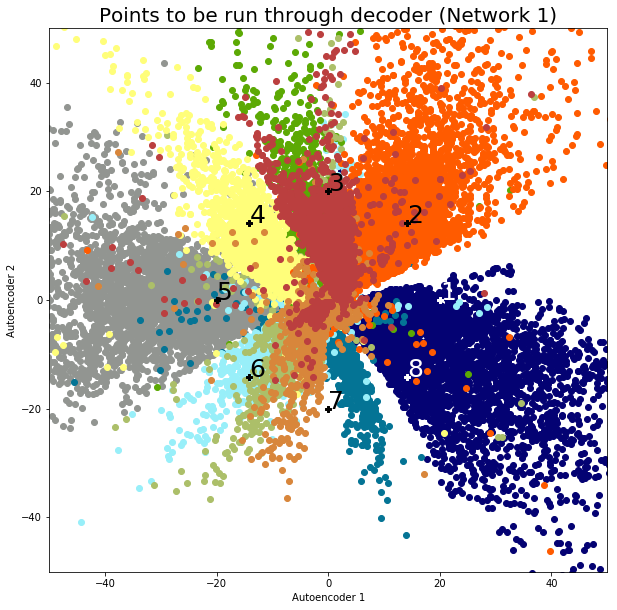

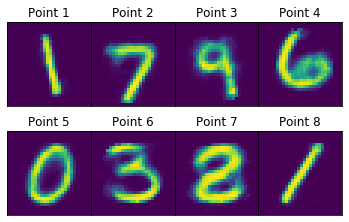

In [130]:
plt.figure(figsize=(10, 10))
plt.title("Points to be run through decoder (Network 1)", fontsize=20)
for i in range(10):
    number = encoded_data_matrix[0, np.where(train_labels == i), :][0, :, :]
    plt.scatter(number[:, 0], number[:, 1], label=i, c=colors[i])
plt.xlim([-50, 50]), plt.ylim([-50, 50])
plt.xlabel("Autoencoder 1"), plt.ylabel("Autoencoder 2")

for i in range(8):
    plt.scatter(sample_pts[i, 0], sample_pts[i, 1],
                c='xkcd:White' if i == 0 or i == 7 else 'k',
                marker='P',
                s=30)
    plt.annotate(str(i+1), (sample_pts[i, 0], sample_pts[i, 1]),
                 color='xkcd:White' if i == 0 or i == 7 else 'k',
                 fontsize=25)
plt.savefig('./figures/decoder_sample_pts.png', bbox_inches='tight')

fig = plt.subplots(2, 4)
for i in range(len(decoded_data_matrix[0])):
    ax = plt.subplot(2, 4, i+1)
    plt.title('Point {}'.format(i+1))
    figi = plt.imshow(decoded_data_matrix[0][i])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig('./figures/decoder_results.png', bbox_inches='tight')